In [157]:
import glob
import multiprocessing
import random
import time
import enum

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchio as tio
import torchvision
import tqdm

from unet import UNet

seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Wed Jul  5 11:31:15 2023
TorchIO version: 0.18.92


# Data Loading and Visualization

## Metadata

In [105]:
metadata_path = "/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")

In [106]:
metadata

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN
...,...,...,...,...,...,...,...,...,...,...
T2Z1Z9,Canon,D,5,29,9,43,HCM,F,162.0,93.0
T9U9W2,Siemens,A,1,0,10,57,HCM,M,160.0,68.0
V4W8Z5,GE,C,4,19,9,39,Other,F,NaN,55.0


## NII files

In [107]:
def get_subjects_names(dir, root_dir="Data/M&Ms/OpenDataset/", verbose=False):
  subjects_names = glob.glob("*", root_dir=root_dir+dir)
  if verbose:
    print(f"subjects for {dir[:-1]}: {len(subjects_names)}")
  return subjects_names

train_subjects = get_subjects_names("Training/Labeled/", verbose=True)
valid_subjects = get_subjects_names("Validation/", verbose=True)
test_subjects = get_subjects_names("Testing/", verbose=True)

subjects for Training/Labeled: 150
subjects for Validation: 33
subjects for Testing: 134


### Extract and Save ROI (only once)

In [108]:
def transform_data(data_dir, metadata, subjects_ids, image_size=128 ,padding_size=10):
  print("Start Transformation")
  for i, subject_id in enumerate(subjects_ids):
    print(i, subject_id)
    ed_index = metadata.loc[subject_id].ED
    es_index = metadata.loc[subject_id].ES

    image = tio.ScalarImage(f"{data_dir}/{subject_id}/{subject_id}_sa.nii.gz")
    seg = tio.LabelMap(f"{data_dir}/{subject_id}/{subject_id}_sa_gt.nii.gz")

    image.set_data(image.data[[ed_index, es_index]])
    seg.set_data(seg.data[[ed_index, es_index]])

    c, w, h, d = seg.shape
    #Optimize this
    min_boundaries = seg.data.nonzero(as_tuple=False).min(axis=0).values[1:-1]
    max_boundaries = seg.data.nonzero(as_tuple=False).max(axis=0).values[1:-1]
    w_init = min_boundaries[0].item() - padding_size
    h_init = min_boundaries[1].item() - padding_size
    w_fin = w - max_boundaries[0].item() - padding_size
    h_fin = h - max_boundaries[1].item() - padding_size

    transform = tio.transforms.Compose([
        tio.transforms.Crop((w_init, w_fin, h_init, h_fin, 0, 0)),
        tio.transforms.Resize((image_size, image_size, d))
        ])

    
    image = transform(image)
    seg = transform(seg)

    

    image.save(f"{data_dir}/{subject_id}/{subject_id}_sa.nii.gz")
    seg.save(f"{data_dir}/{subject_id}/{subject_id}_sa_gt.nii.gz")


    if i%20==0:
      print(i+1, "files saved")

  print("Transformation Complete")   

In [109]:
##Only run once
#transform_data("Data/M&Ms/OpenDataset/Training/Labeled", metadata, train_subjects)
#transform_data("Data/M&Ms/OpenDataset/Validation", metadata, valid_subjects)
#transform_data("Data/M&Ms/OpenDataset/Testing", metadata, test_subjects)

### Load data

Medical images can be oriented in many different ways. To ensure a consistent orientation across our dataset, we can use a preprocessing transform.

ToCanonical reorganizes the voxels positions and the associated affine matrix so that the image is now in RAS+ orientation, i.e. the voxels indices will grow from left to right, from posterior (back) to anterior (nose) and from inferior (feet) to superior (head), respectively.

In [110]:
def load_data(data_dir, metadata, subjects_ids, transform=tio.ToCanonical()):
  subjects = []
  for subject_id in subjects_ids:
    image = tio.ScalarImage(f"{data_dir}/{subject_id}/{subject_id}_sa.nii.gz")
    seg = tio.LabelMap(f"{data_dir}/{subject_id}/{subject_id}_sa_gt.nii.gz")

    subject = tio.Subject(
        image = image,
        seg = seg,
        subject_id = subject_id, 
        meta = metadata.loc[subject_id],
        d = seg.shape[3]
    )

    subjects.append(transform(subject))

  dataset = tio.SubjectsDataset(subjects)
  print(data_dir ,'Dataset size:', len(dataset), 'subjects')

  return dataset     

In [150]:
transform = tio.Compose([
tio.RescaleIntensity((0,1)),
    tio.ToCanonical()
])


train_dataset = load_data("Data/M&Ms/OpenDataset/Training/Labeled", metadata, train_subjects, transform)
valid_dataset = load_data("Data/M&Ms/OpenDataset/Validation", metadata, valid_subjects, transform)
#E3F5U2, C8O0P2 were removed from test
test_dataset = load_data("Data/M&Ms/OpenDataset/Testing", metadata, test_subjects, transform)

Data/M&Ms/OpenDataset/Testing Dataset size: 134 subjects


Subject(Keys: ('image', 'seg', 'subject_id', 'meta', 'd'); images: 2)
ScalarImage(shape: (2, 12, 128, 128); spacing: (9.60, 1.22, 1.12); orientation: PRS+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 12, 128, 128); spacing: (9.60, 1.22, 1.12); orientation: PRS+; dtype: torch.FloatTensor; memory: 1.5 MiB)
VendorName    Siemens
Vendor              A
Centre              1
ED                  0
ES                 13
Age                67
Pathology         DCM
Sex                 M
Height          158.0
Weight           65.0
Name: T2T9Z9, dtype: object


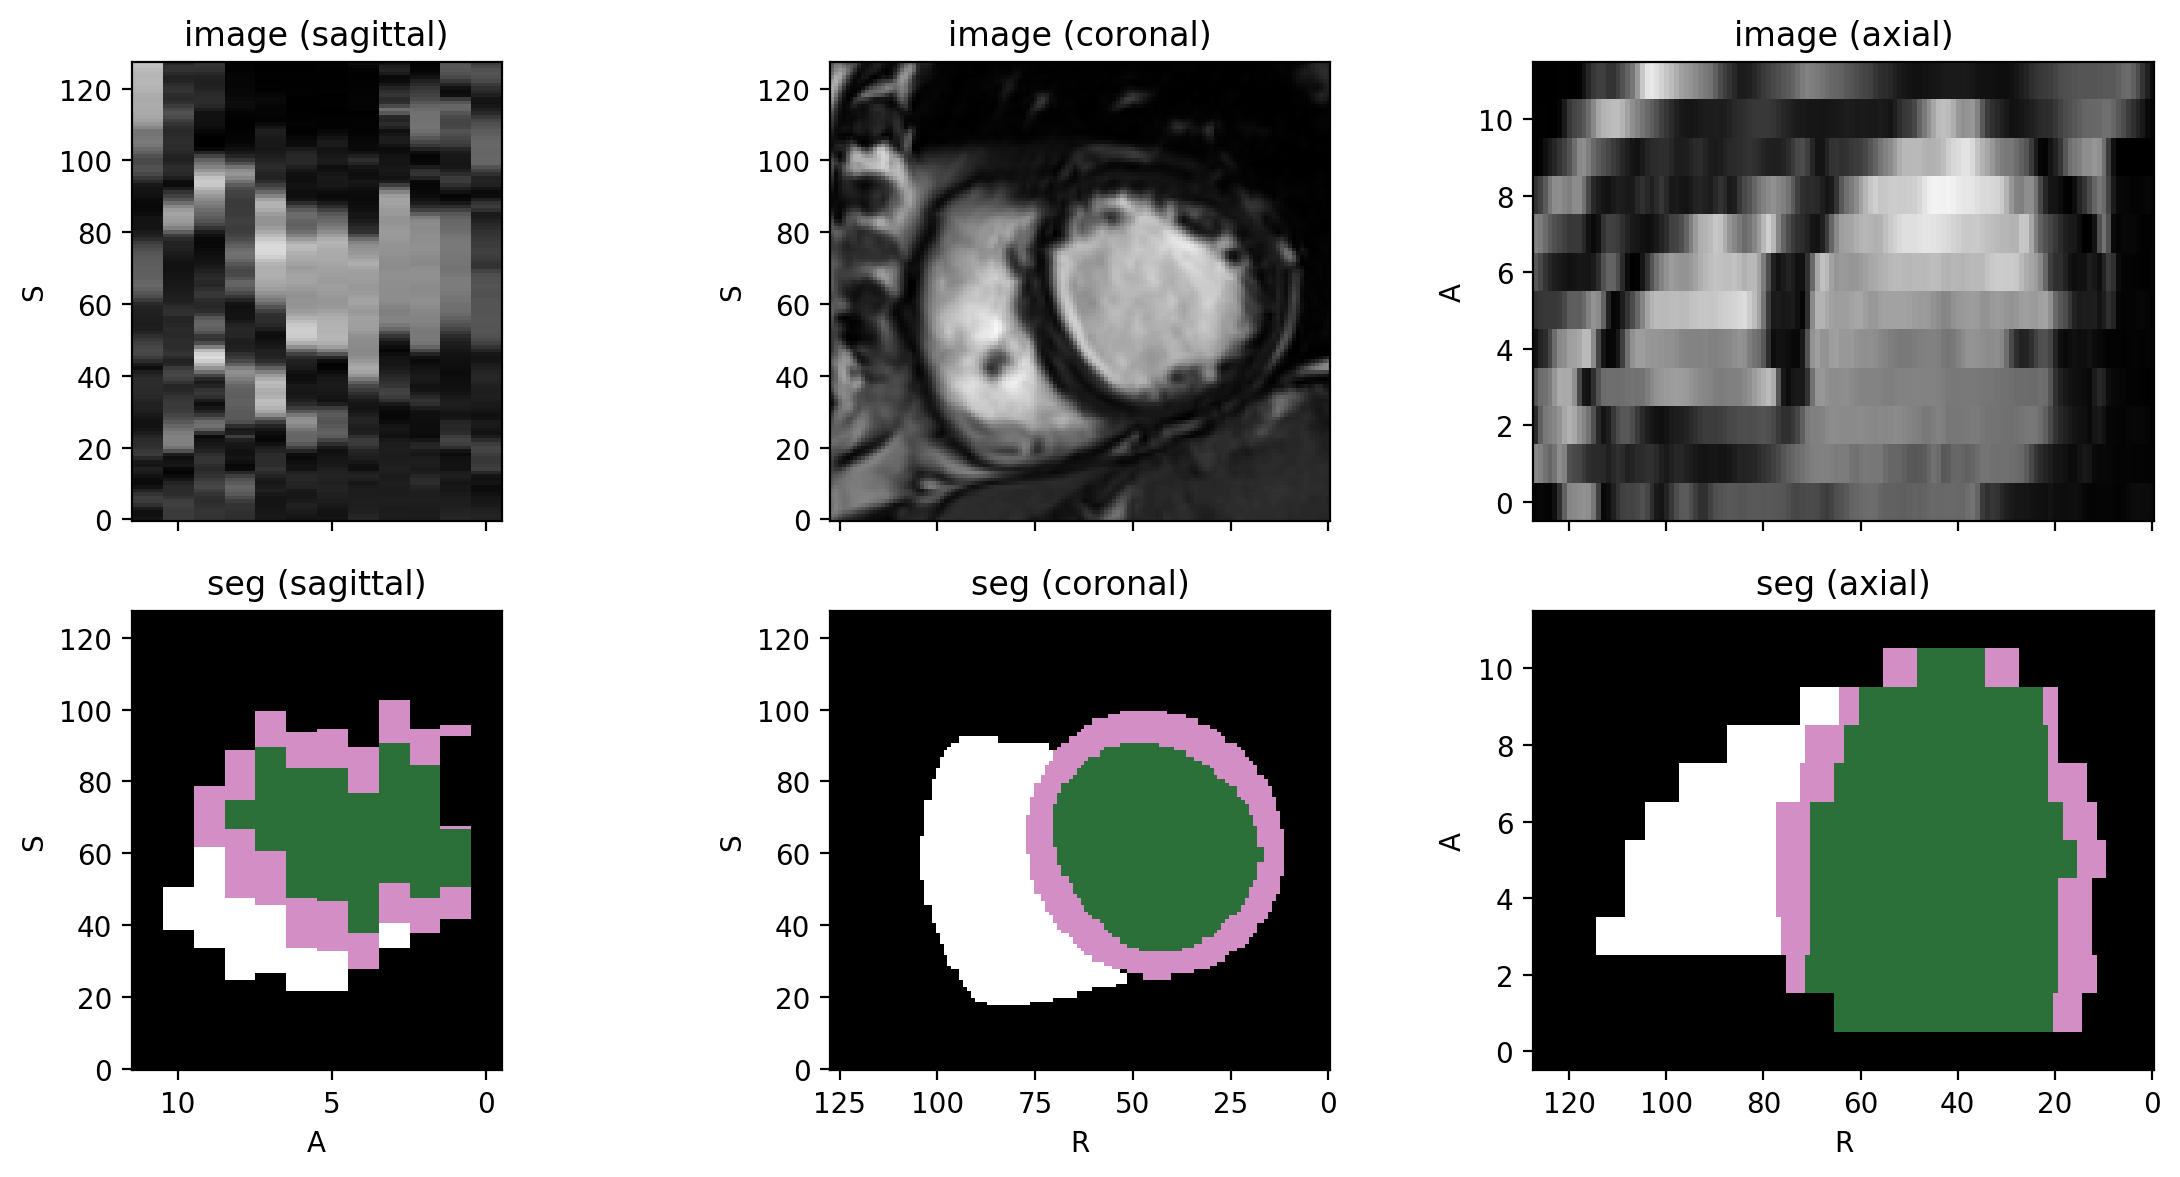

In [112]:
# Visualize one subject
one_subject = train_dataset[0]
print(one_subject)
print(one_subject.image)
print(one_subject.seg)
print(one_subject.meta)
one_subject.plot(channel=0) #ED channel 0 #ES channel 1

### Resampling

ScalarImage(shape: (2, 12, 156, 144); spacing: (10.00, 1.00, 1.00); orientation: PRS+; dtype: torch.FloatTensor; memory: 2.1 MiB)
LabelMap(shape: (2, 12, 156, 144); spacing: (10.00, 1.00, 1.00); orientation: PRS+; dtype: torch.FloatTensor; memory: 2.1 MiB)


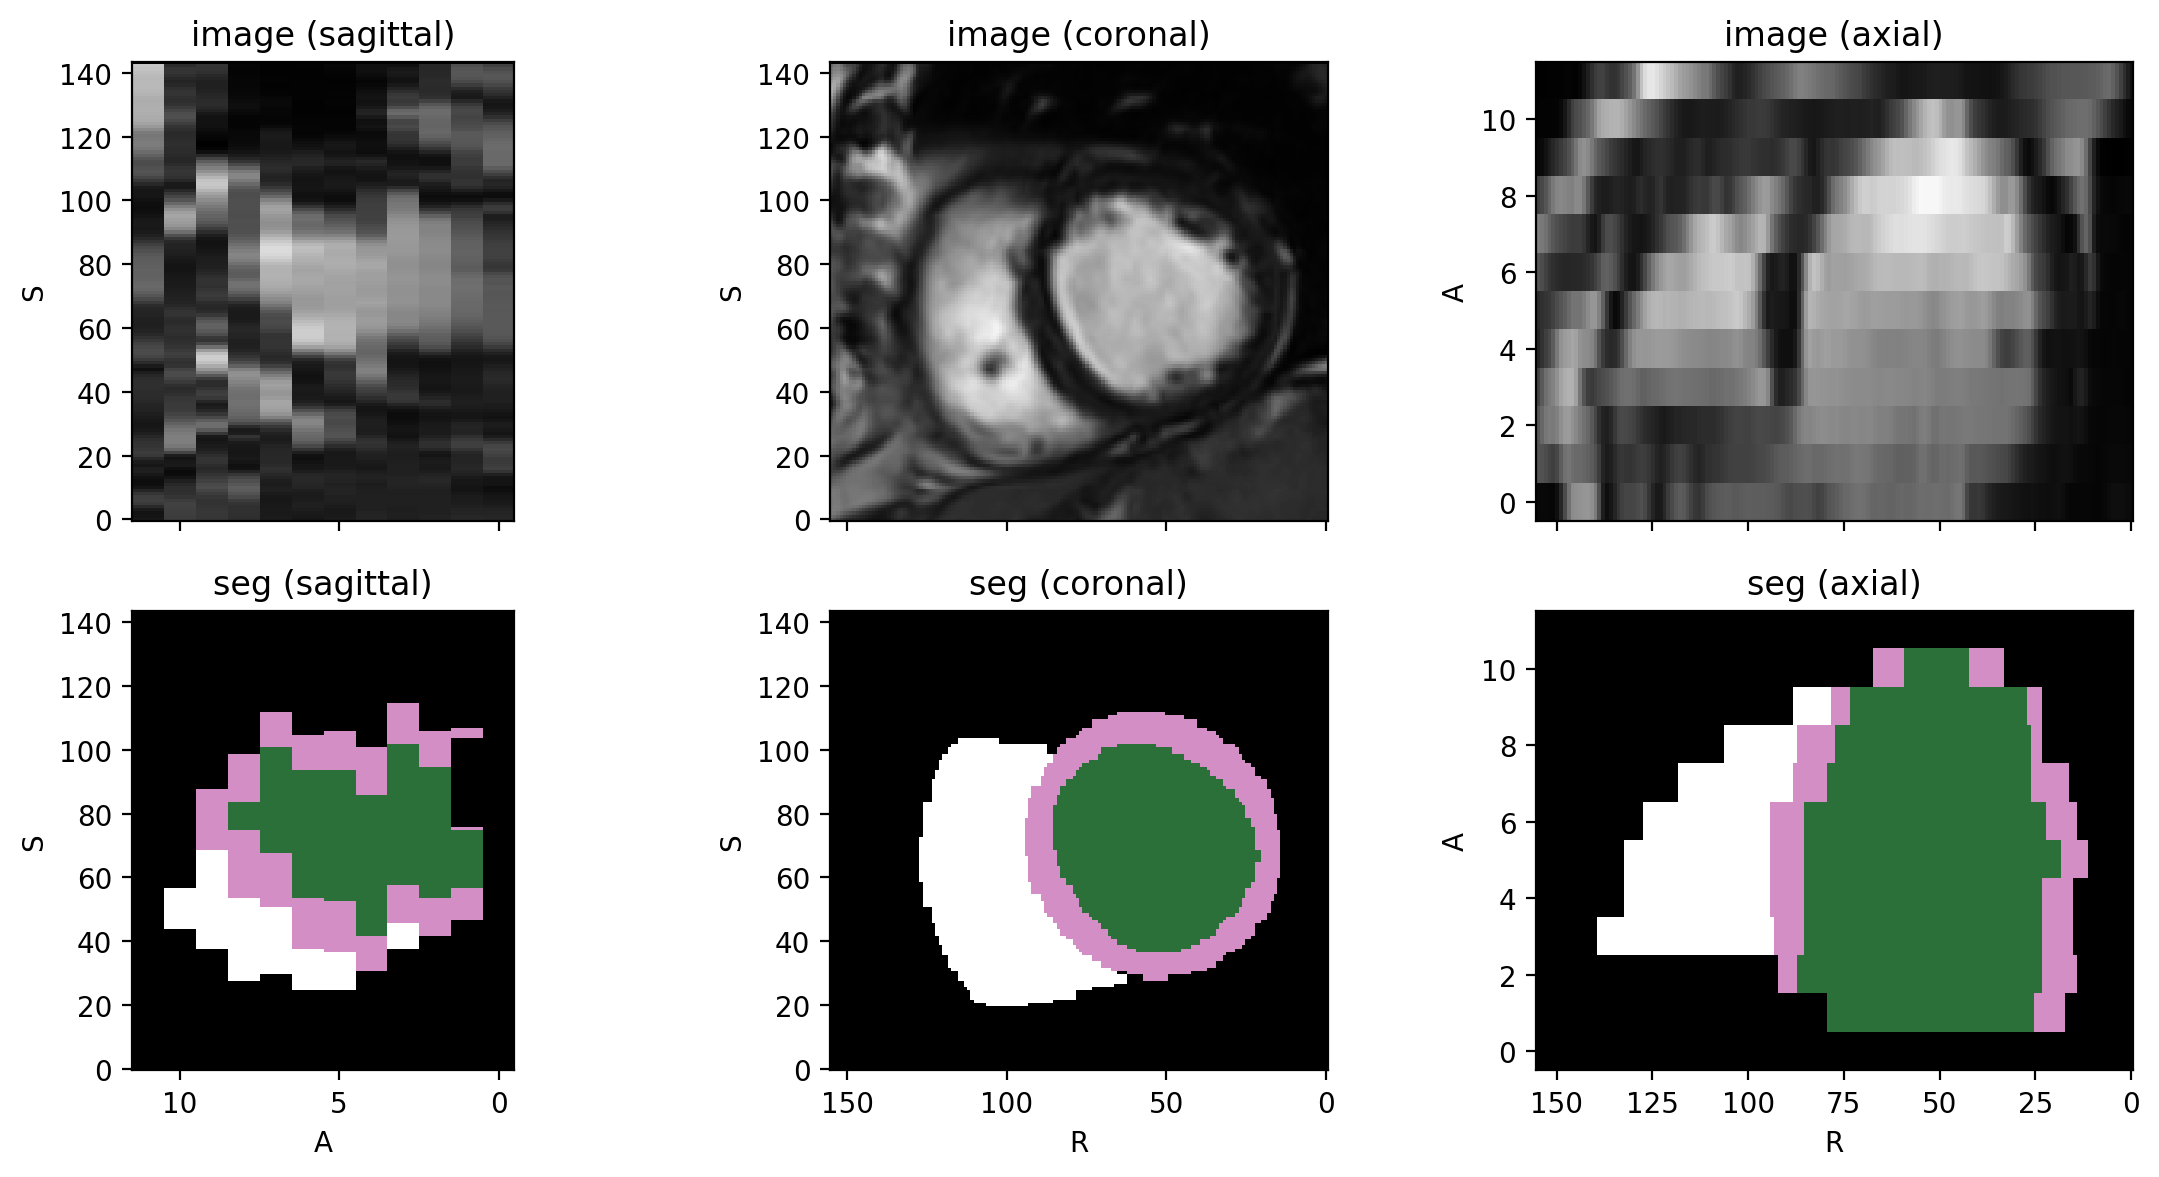

In [113]:
resample = tio.Resample((10,1,1))
resampled = resample(one_subject)
print(resampled.image)
print(resampled.seg)
resampled.plot(channel=0)


### View Histograms

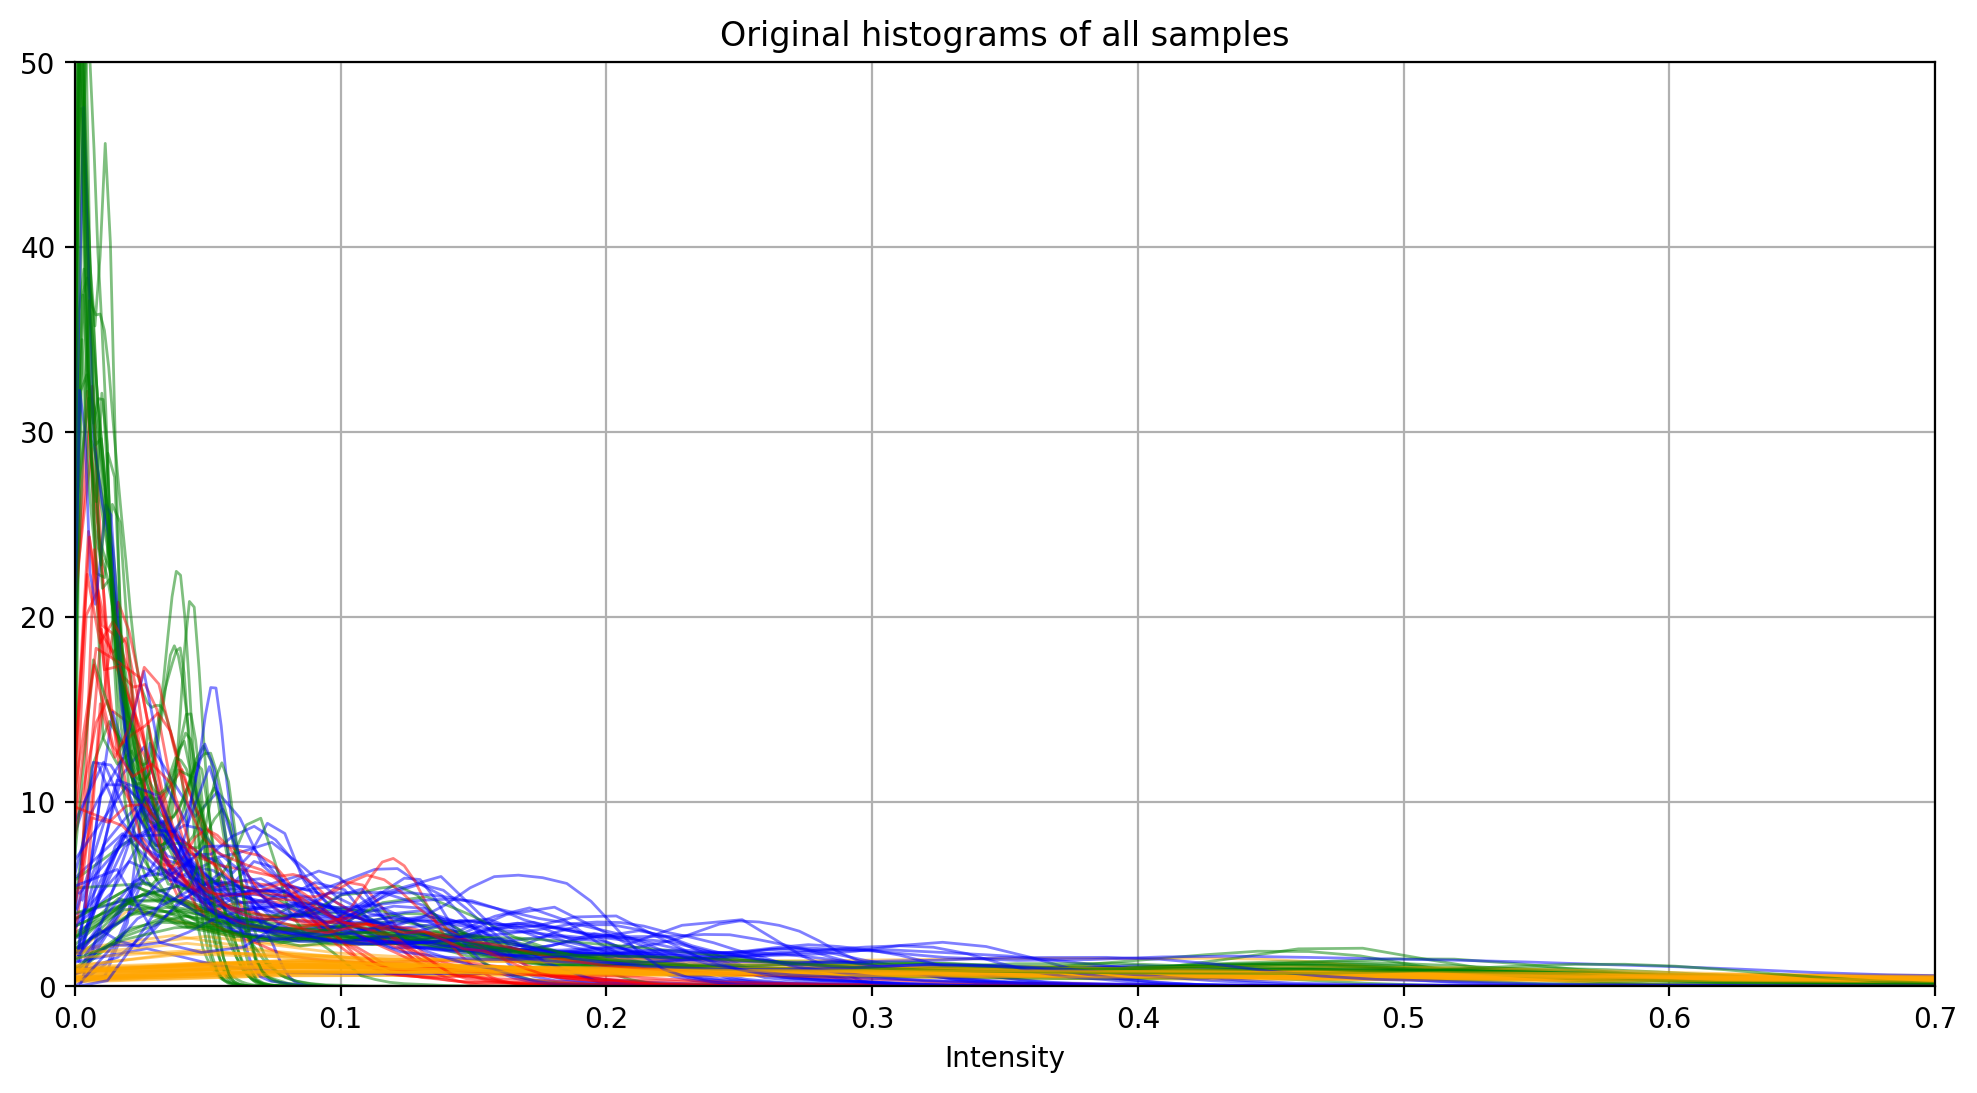

In [153]:
def plot_histogram(axis, tensor, num_positions=50, label=None, alpha=0.5, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram,**kwargs)


fig, ax = plt.subplots(dpi=100)
for subject in test_dataset:
    tensor = subject.image.data
    if subject.meta.Vendor=="A": color = 'red'
    elif subject.meta.Vendor=="B": color = 'green'
    elif subject.meta.Vendor=="C": color = 'blue'
    else: color = 'orange'
    plot_histogram(ax, tensor, color=color)
ax.set_xlim(0, 0.7)
ax.set_ylim(0, 50)
ax.set_title('Original histograms of all samples')
ax.set_xlabel('Intensity')
ax.grid()


### Vendor partition

In [135]:
def plot_distribution(attribute, subjects, metadata,kind='pie'):
    data = {attribute: [metadata.loc[index][attribute] for index in subjects]}
    partition = pd.DataFrame(data)
    partition[attribute].value_counts().plot(kind=kind)
    plt.title(f"Distribution over {attribute}")

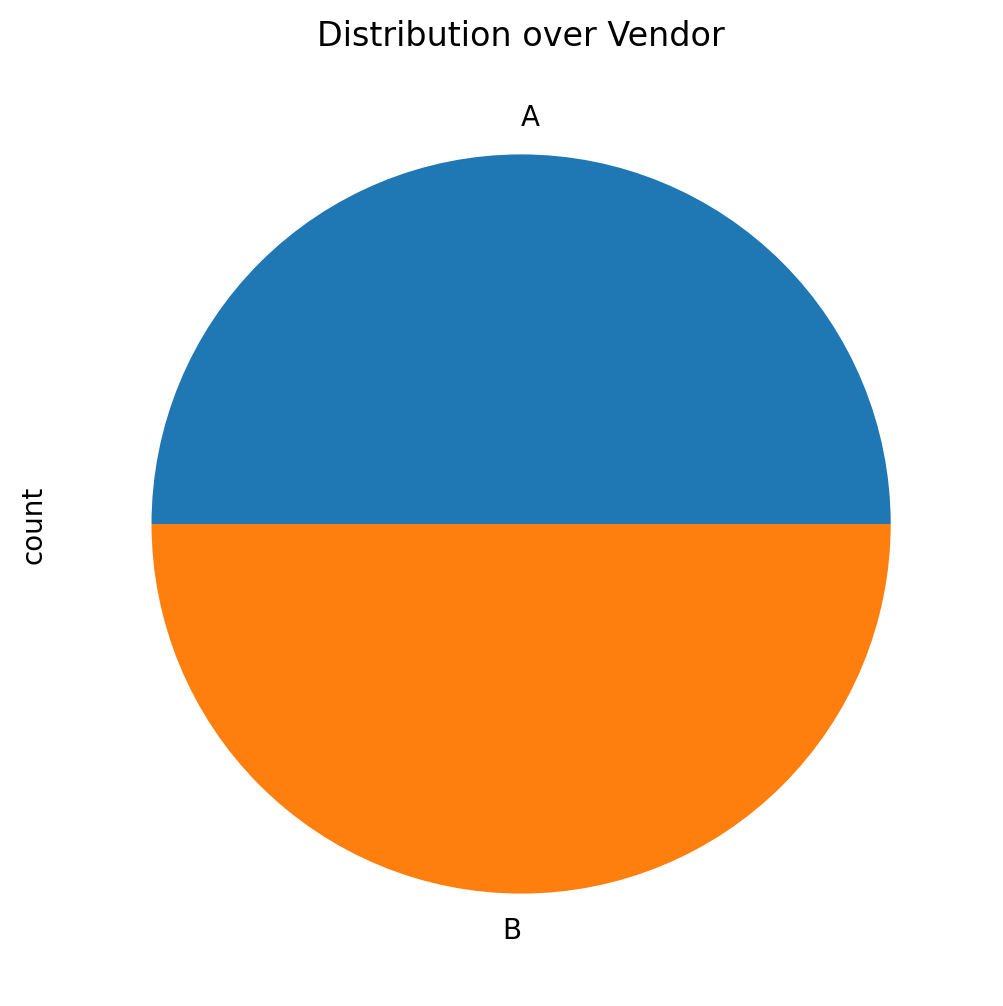

In [144]:
plot_distribution("Vendor", train_subjects, metadata)

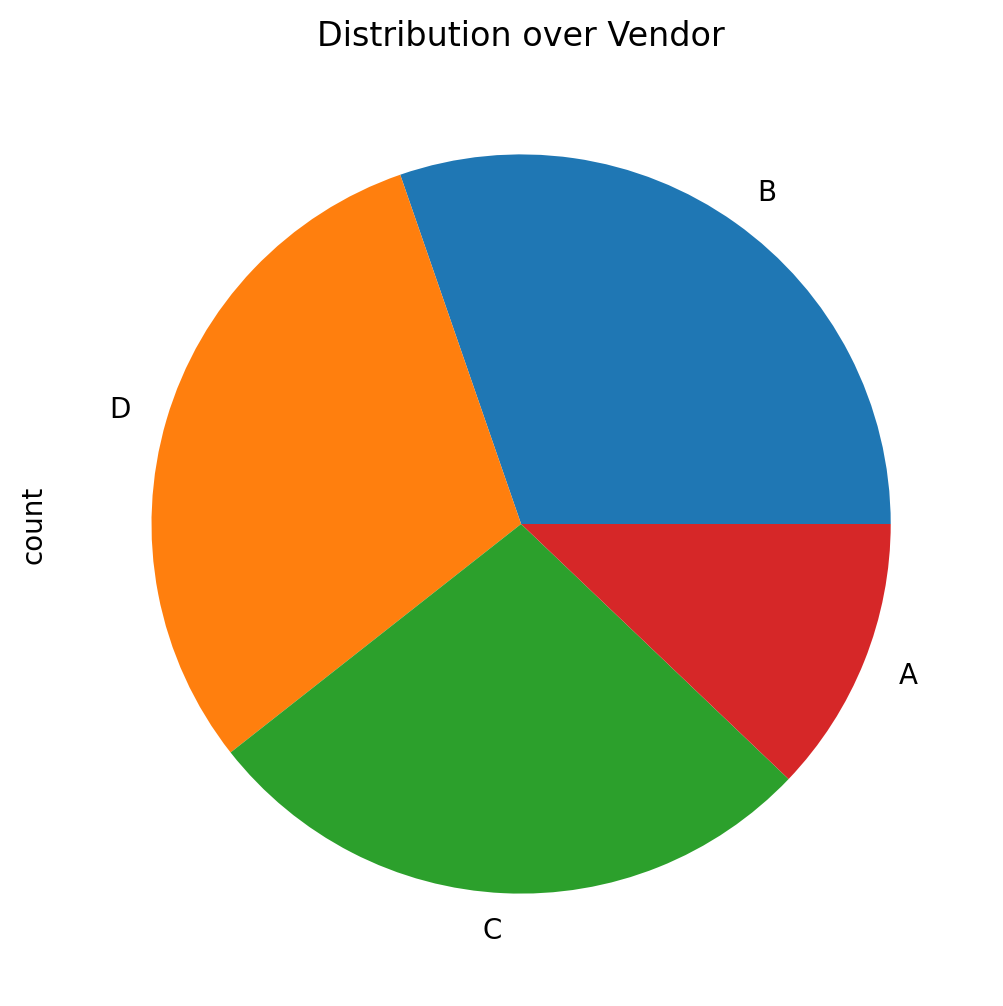

In [148]:
plot_distribution("Vendor", valid_subjects, metadata)

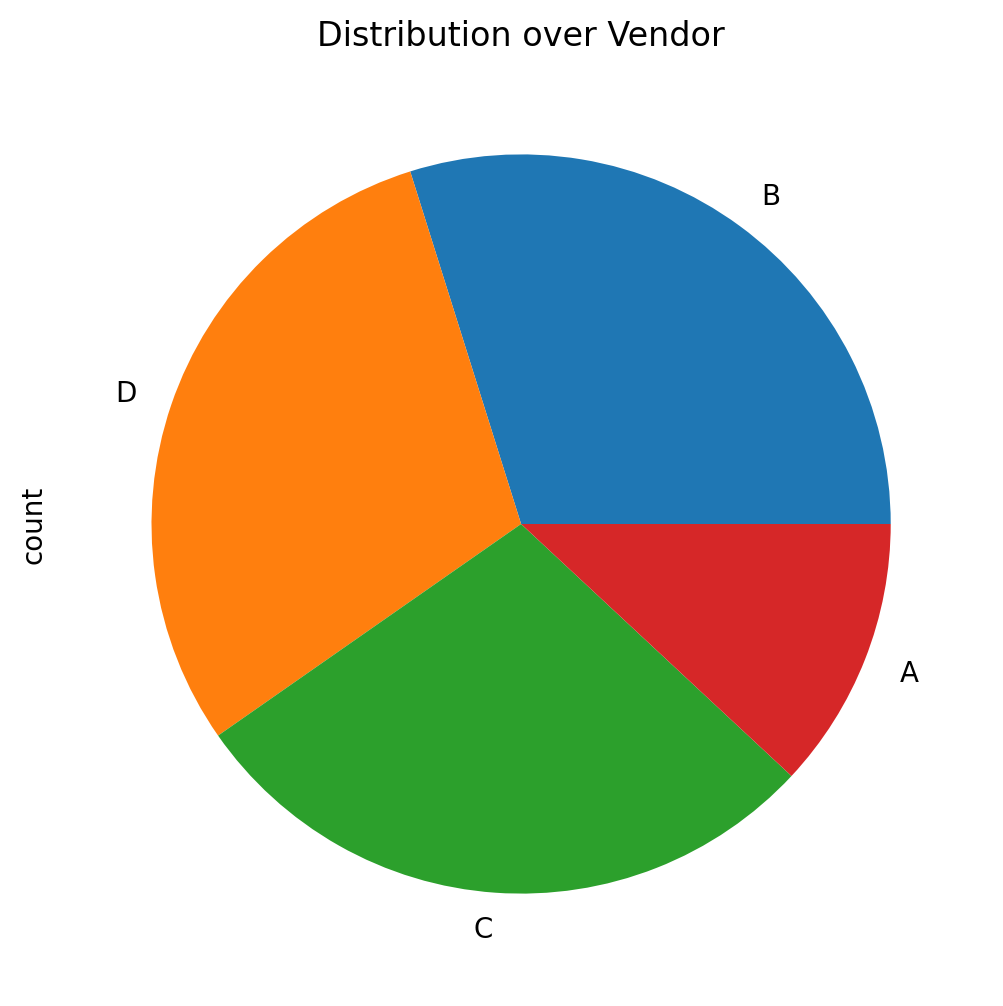

In [147]:
plot_distribution("Vendor", test_subjects, metadata)

### Memory usage

In [116]:
def humanbytes(B):
    """Return the given bytes as a human friendly KB, MB, GB, or TB string."""
    B = float(B)
    KB = float(1024)
    MB = float(KB ** 2) # 1,048,576
    GB = float(KB ** 3) # 1,073,741,824
    TB = float(KB ** 4) # 1,099,511,627,776

    if B < KB:
        return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
    elif KB <= B < MB:
        return '{0:.2f} KB'.format(B / KB)
    elif MB <= B < GB:
        return '{0:.2f} MB'.format(B / MB)
    elif GB <= B < TB:
        return '{0:.2f} GB'.format(B / GB)
    elif TB <= B:
        return '{0:.2f} TB'.format(B / TB)

In [117]:
def get_total_memory(dataset, image_types=["image", "seg"]):
  memory_usage = [sum([subject[image].memory for image in image_types]) for subject in dataset.dry_iter()]
  return sum(memory_usage)
# for i, B in enumerate(memory_usage):
#   print(f"Memory used for subject {i}: {humanbytes(B)}")
print("Total memory for train: ", humanbytes(get_total_memory(train_dataset)))
print("Total memory for test: ", humanbytes(get_total_memory(test_dataset)))
print("Total memory for valid: ", humanbytes(get_total_memory(valid_dataset)))

Total memory for train:  410.75 MB
Total memory for test:  400.00 MB
Total memory for valid:  98.25 MB


# Unet

In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
# CHANNELS_DIMENSION = 1
# SPATIAL_DIMENSIONS = 2, 3, 4

# class Action(enum.Enum):
#     TRAIN = 'Training'
#     VALIDATE = 'Validation'

# def prepare_batch(batch, device):
#     inputs = batch['image'][tio.DATA].to(device)
#     targets = batch['seg'][tio.DATA].to(device)
#     return inputs, targets

# def get_dice_score(output, target, epsilon=1e-9):
#     p0 = output
#     g0 = target
#     p1 = 1 - p0
#     g1 = 1 - g0
#     tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
#     fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
#     fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
#     num = 2 * tp
#     denom = 2 * tp + fp + fn + epsilon
#     dice_score = num / denom
#     return dice_score

# def get_dice_loss(output, target):
#     return 1 - get_dice_score(output, target)

# def get_model_and_optimizer(device):
#     model = UNet(
#         in_channels=1,
#         out_classes=4,
#         dimensions=3,
#         num_encoding_blocks=4,
#         out_channels_first_layer=8,
#         normalization='batch',
#         upsampling_type='linear',
#         padding=True,
#         activation='PReLU',
#     ).to(device)
#     optimizer = torch.optim.AdamW(model.parameters())
#     return model, optimizer

# def run_epoch(epoch_idx, action, loader, model, optimizer):
#     is_training = action == Action.TRAIN
#     epoch_losses = []
#     times = []
#     model.train(is_training)
#     for batch_idx, batch in enumerate(tqdm(loader)):
#         inputs, targets = prepare_batch(batch, device)
#         optimizer.zero_grad()
#         with torch.set_grad_enabled(is_training):
#             logits = model(inputs)
#             probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
#             batch_losses = get_dice_loss(probabilities, targets)
#             batch_loss = batch_losses.mean()
#             if is_training:
#                 batch_loss.backward()
#                 optimizer.step()
#             times.append(time.time())
#             epoch_losses.append(batch_loss.item())
#     epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
#     return times, epoch_losses

# def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
#     train_losses = []
#     val_losses = []
#     val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
#     for epoch_idx in range(1, num_epochs + 1):
#         print('Starting epoch', epoch_idx)
#         train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
#         val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
#         torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
#     return np.array(train_losses), np.array(val_losses)

In [159]:
# training_batch_size = 16
# validation_batch_size = 2 * training_batch_size

# training_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=training_batch_size,
#     shuffle=True,
#     num_workers=num_workers,
# )

# validation_loader = torch.utils.data.DataLoader(
#     valid_dataset,
#     batch_size=validation_batch_size,
#     num_workers=num_workers,
# )

In [ ]:
# k = 24
# batch_mri = one_batch['mri'][tio.DATA][..., k]
# batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
# slices = torch.cat((batch_mri, batch_label))
# image_path = 'batch_whole_images.png'
# torchvision.utils.save_image(
#     slices,
#     image_path,
#     nrow=training_batch_size//2,
#     normalize=True,
#     scale_each=True,
#     padding=0,
# )
# display.Image(image_path)